In [993]:
from ppget.source import ModelSource, prepare_filesystem

WINDOW = 4
MODEL_NAME = "model/cnn1d_time_cluster/"

start_date = "2007-07-01"
end_date = "2008-08-06"
# end_date = "2009-06-01"
feature = "Global_active_power"

prepare_filesystem(MODEL_NAME)
source = ModelSource.load(start_date, end_date, feature)
source.missing_data()

Series([], Freq: 10T, Name: Global_active_power, dtype: float64)

In [994]:
series = source.series()
series.describe()

count    57888.000000
mean         1.088116
std          1.051975
min          0.078000
25%          0.294200
50%          0.591100
75%          1.548200
max          8.514600
Name: Global_active_power, dtype: float64

In [995]:
%%time
from sklearn.cluster import KMeans
import pandas as pd

daily_slices = 4

year_split = int(len(series) * 0.9)
l1 = 0
kw_hour = pd.DataFrame(zip(list(series.values),list(series.index.hour)))
d_kmeans = KMeans(n_clusters=daily_slices).fit(kw_hour[l1:year_split])

CPU times: user 2.6 s, sys: 1.2 s, total: 3.8 s
Wall time: 523 ms


In [996]:
import pickle

pickle.dump(d_kmeans, open(f"{MODEL_NAME}cluster/d_kmeans.pkl", "wb"))

In [997]:
%%time
monthly_slices = 3

kw_month = pd.DataFrame(zip(list(series.values),list(series.index.month)))
m_kmeans = KMeans(n_clusters=monthly_slices).fit(kw_month[l1:year_split])

CPU times: user 3.04 s, sys: 1.04 s, total: 4.07 s
Wall time: 406 ms


In [998]:
# pickle.dump(m_kmeans, open(f"{MODEL_NAME}cluster/m_kmeans.pkl", "wb"))

In [999]:
weekly_slices = 3

kw_day = pd.DataFrame(zip(list(series.values),list(series.index.dayofweek)))
w_kmeans = KMeans(n_clusters=weekly_slices).fit(kw_day[l1:year_split])

In [1000]:
# pickle.dump(w_kmeans, open(f"{MODEL_NAME}cluster/w_kmeans.pkl", "wb"))

In [1001]:
cluster_map = pd.DataFrame(zip(list(d_kmeans.predict(kw_hour)),list(w_kmeans.predict(kw_day)),list(m_kmeans.predict(kw_month))))
cluster_map.columns = ["daily_slice", "weekly_slice", "monthly_slice"]
cluster_map.head()

,daily_slice,weekly_slice,monthly_slice
0,1,2,2
1,1,2,2
2,1,2,2
3,1,2,2
4,1,2,2


In [1002]:
from ppget.training import DatasetBuilder, TrainSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
import numpy as np

d_kmeans = pickle.load(open(f"{MODEL_NAME}cluster/d_kmeans.pkl", "rb"))
# w_kmeans = pickle.load(open(f"{MODEL_NAME}cluster/w_kmeans.pkl", "rb"))
# m_kmeans = pickle.load(open(f"{MODEL_NAME}cluster/m_kmeans.pkl", "rb"))

values = series.values.reshape((len(series.values), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
normaliser = scaler.fit(values)
original_frame = normaliser.transform(values)

plus_s_day = np.append(original_frame, LabelBinarizer().fit_transform(d_kmeans.predict(kw_hour)), axis=1)
# plus_s_week = np.append(plus_s_day, LabelBinarizer().fit_transform(w_kmeans.predict(kw_day)), axis=1)
# plus_s_month = np.append(plus_s_day, LabelBinarizer().fit_transform(m_kmeans.predict(kw_month)), axis=1)

encoded_seasons = pd.DataFrame(plus_s_day)
encoded_seasons.head()

,0,1,2,3,4
0,0.308560,0.0,1.0,0.0,0.0
1,0.304886,0.0,1.0,0.0,0.0
2,0.302089,0.0,1.0,0.0,0.0
3,0.289951,0.0,1.0,0.0,0.0
4,0.298936,0.0,1.0,0.0,0.0


In [1003]:
builder = DatasetBuilder(encoded_seasons, data_split=TrainSplit(), window_size=WINDOW, normalised=False, all_features=True)

S = builder.build_splits()

S["training"]["X"].shape, S["training"]["y"].shape, S["test"]["X"].shape, S["test"]["y"].shape

((52095, 4, 5), (52095,), (5789, 4, 5), (5789,))

In [1004]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from tensorflow.python.keras.metrics import RootMeanSquaredError
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()
model.add(InputLayer((WINDOW,
                      daily_slices +
                      # weekly_slices +
                      # monthly_slices +
                      1)))
model.add(Conv1D(8, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(4, 'relu'))
model.add(Dense(1, 'linear'))
callbacks = [ModelCheckpoint(MODEL_NAME, monitor="val_loss", save_best_only=True, mode="min"), EarlyStopping(patience=4, monitor="val_loss")]
model.compile(loss="mse", optimizer="adam", metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 3, 8)              88        
_________________________________________________________________
flatten_72 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_144 (Dense)            (None, 4)                 100       
_________________________________________________________________
dense_145 (Dense)            (None, 1)                 5         
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [1005]:
%%time
h = model.fit(S["training"]["X"], S["training"]["y"],
                    epochs=100,
                    batch_size=16,
                    validation_split=0.2,
                    verbose=2,
                    callbacks=callbacks)
print(f"min RMSE(validation): {min(h.history['val_loss'])}")

Epoch 1/100
2605/2605 - 7s - loss: 0.0117 - root_mean_squared_error: 0.1080 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0615
INFO:tensorflow:Assets written to: model/cnn1d_time_cluster/assets
Epoch 2/100
2605/2605 - 6s - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0593
INFO:tensorflow:Assets written to: model/cnn1d_time_cluster/assets
Epoch 3/100
2605/2605 - 6s - loss: 0.0038 - root_mean_squared_error: 0.0615 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0599
Epoch 4/100
2605/2605 - 6s - loss: 0.0038 - root_mean_squared_error: 0.0614 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0596
Epoch 5/100
2605/2605 - 6s - loss: 0.0038 - root_mean_squared_error: 0.0613 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0601
Epoch 6/100
2605/2605 - 6s - loss: 0.0037 - root_mean_squared_error: 0.0612 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592
INFO:tensorflow:Assets written to: model/cnn1d_time_cluster/assets
E

In [1006]:
%%time
from tensorflow.python.keras.models import load_model

model = load_model(MODEL_NAME)

predictions = model.predict(S["test"]["X"]).flatten()
len(predictions)

CPU times: user 736 ms, sys: 50.6 ms, total: 786 ms
Wall time: 741 ms


5789

In [1007]:
import pandas as pd

test_results = pd.DataFrame(data={"Predictions": predictions, "Ground Truth": S["test"]["y"]})
test_results.head()

,Predictions,Ground Truth
0,0.204308,0.223336
1,0.230274,0.103952
2,0.090165,0.032003
3,0.037801,0.104497
4,0.127800,0.205604


In [1008]:
from ppget.metrics import ModelEvaluation

print(ModelEvaluation(expected=test_results["Ground Truth"][:-1],
                      predicted=test_results["Predictions"].shift(-1)[:-1],
                      m=3,
                      model_path=MODEL_NAME))

Model Scores - (R2): 0.969, (Adj R2): 0.969, (RMSE): 0.015 KW. Model Size - 332173 bytes.


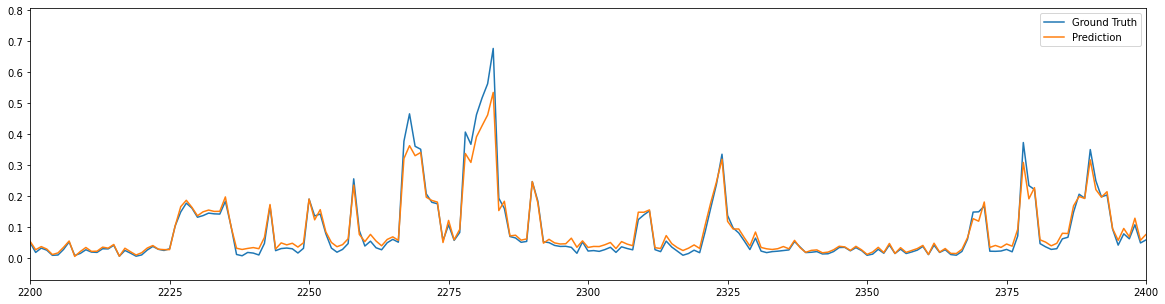

In [1009]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(test_results["Ground Truth"], label="Ground Truth")
ax.plot(test_results["Predictions"].shift(-1), label="Prediction")

plt.legend(["Ground Truth", "Prediction"])
plt.xlim([2200, 2400])
plt.show()